In [37]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
#from tabulate import tabulate

In [2]:
#Web Scraping - https://pythonprogramminglanguage.com/web-scraping-with-pandas-and-beautifulsoup/
res = requests.get("http://www.fedearroz.com.co/new/precios.php")
soup = BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))
#print( tabulate(df[0], headers='keys', tablefmt='psql') )

In [3]:
#Data Wrangling
arroz=df[0]
arroz.columns = arroz.iloc[0]
arroz = arroz.set_index(['Mes'])
arroz = arroz.drop(['Mes'])
arroz = arroz.rename(index={'Enero': '1', 
                            'Febrero': '2', 
                            'Marzo': '3', 
                            'Abril': '4', 
                            'Mayo': '5',
                            'Junio': '6',
                            'Julio': '7',
                            'Agosto': '8',
                            'Septiembre': '9',
                            'Octubre': '10',
                            'Noviembre': '11',
                            'Diciembre': '12'})
arroz = arroz.reset_index()
arroz = pd.melt(arroz, id_vars=['Mes'],var_name='Year',value_name='Price')
arroz = arroz.rename(columns={'Mes': 'Month'})
arroz['Year'] = arroz['Year'].astype(int)
arroz['Month'] = arroz['Month'].astype(int)
arroz = arroz.dropna()

#pd.to_datetime((df.Y*10000+df.M*100+df.D).apply(str),format='%Y%m%d')
arroz['Date']=pd.to_datetime((arroz.Year*10000+arroz.Month*100+1).apply(str),format='%Y%m%d')

arroz=arroz[['Date','Price']]
arroz['Price']=arroz['Price']/1000

arroz = arroz.set_index('Date')

In [4]:
arroz.head(12)

,Price
Date,
2010-01-01,817.456
2010-02-01,884.395
2010-03-01,796.473
2010-04-01,787.395
2010-05-01,803.395
2010-06-01,853.903
2010-07-01,797.759
2010-08-01,816.705
2010-09-01,848.036


In [5]:
arroz.tail(8)

,Price
Date,
2018-01-01,875.371
2018-02-01,895.089
2018-03-01,910.929
2018-04-01,919.643
2018-05-01,944.357
2018-06-01,950.000
2018-07-01,936.536
2018-08-01,926.886


/home/drivera/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

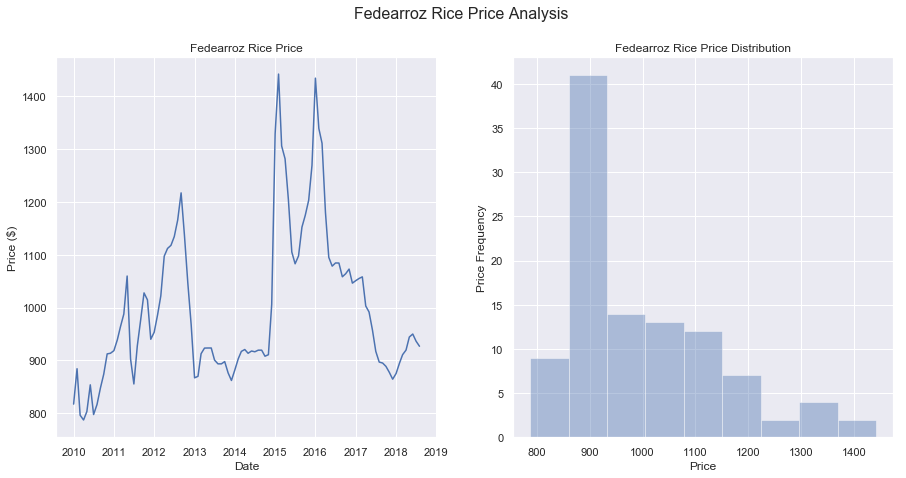

In [6]:
#Timeseries and Distribuition Plot

fig = plt.figure()
sns.set()

f, axs = plt.subplots(2,2,figsize=(15,7))

plt.subplot(121)
sns.lineplot(x=arroz.index, 
             y="Price", 
             data=arroz)
plt.title('Fedearroz Rice Price')
plt.ylabel('Price ($)')

plt.subplot(122)
sns.distplot(arroz.Price,
                    kde=False,
                    color="b")
plt.title('Fedearroz Rice Price Distribution')
plt.ylabel('Price Frequency')

plt.suptitle('Fedearroz Rice Price Analysis', fontsize=16)
plt.show()


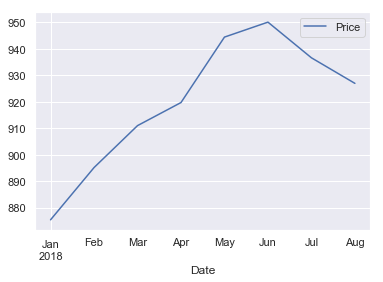

In [7]:
arroz2018 = arroz['2018']
arroz2018.plot()

In [8]:
quarterly = arroz['Price'].resample('Q')
quarterly_mean = quarterly.mean()

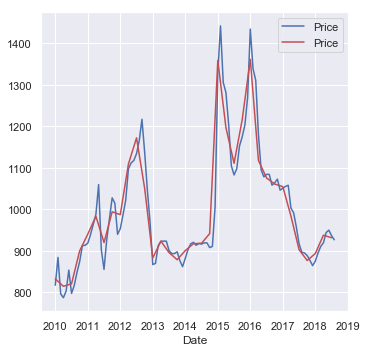

In [9]:
fig = plt.figure(figsize=(5.5, 5.5))
ax = fig.add_subplot(1,1,1)

arroz['Price'].plot(ax=ax, color='b')
quarterly_mean.plot(ax=ax, color='r')

ax.legend()

plt.show()

In [10]:
import fbprophet

In [11]:
# Prophet requires columns ds (Date) and y (value)
arroz_pred = arroz.reset_index()
arroz_pred = arroz_pred.rename(columns={'Date': 'ds', 'Price': 'y'})

# Make the prophet model and fit on the data
arroz_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
arroz_prophet.fit(arroz_pred)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/drivera/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [12]:
# Make a future dataframe for 2 years
arroz_forecast = arroz_prophet.make_future_dataframe(periods=12 * 1, freq='M')

# Make predictions
arroz_forecast = arroz_prophet.predict(arroz_forecast)

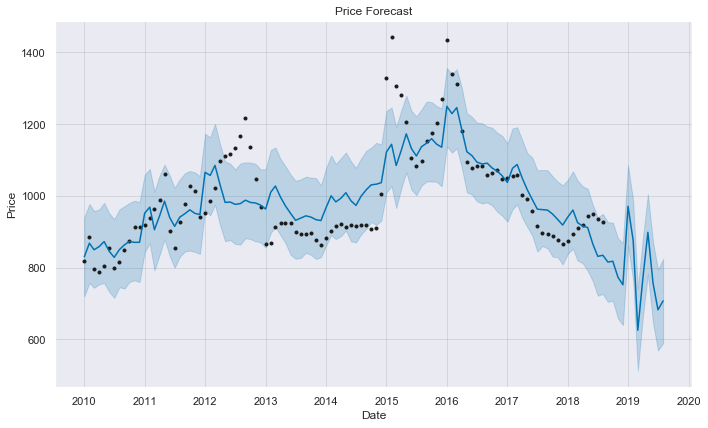

In [13]:
arroz_prophet.plot(arroz_forecast, xlabel = 'Date', ylabel = 'Price')
plt.title('Price Forecast')
plt.savefig('Price Forecast.png')

The black dots represent the actual values (notice how they stop at  2018), the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty (always a critical part of any prediction). The region of uncertainty increases the further out in the future the prediction is made because initial uncertainty propagates and grows over time.

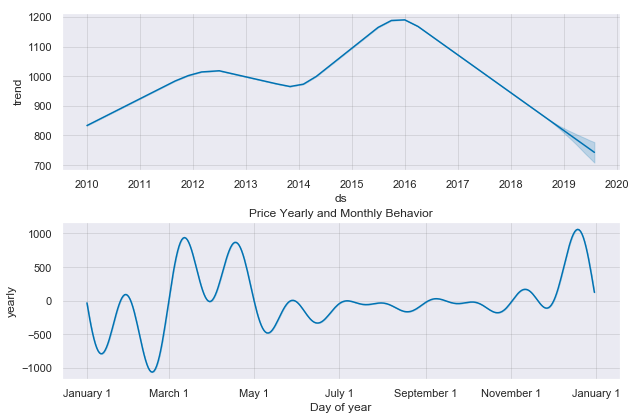

In [14]:
#forecast components
fig2 = arroz_prophet.plot_components(arroz_forecast)
plt.title('Price Yearly and Monthly Behavior')
plt.savefig('Price Yearly and Monthly Behavior.png')
plt.show()


According to this analysis it is expected that for the last months of this year the price will begin to fall, and rise drastically at the beginning of next year, and rice again between march and may. The yearly trend indicates that the price may fall for the next 12 months.

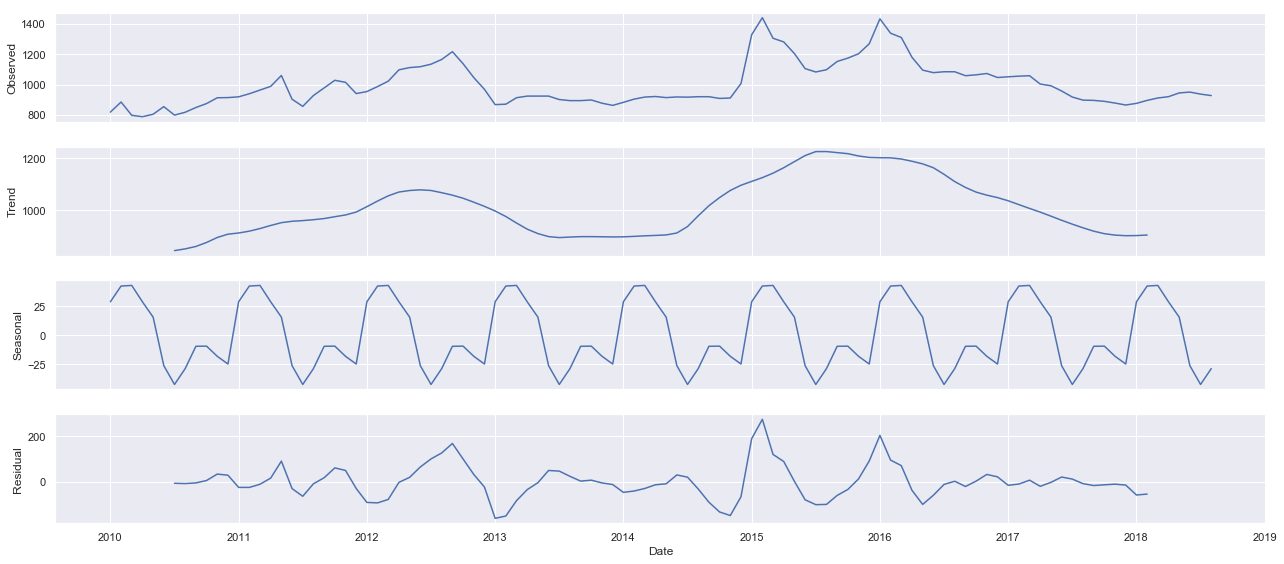

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(arroz['Price'], model='additive')
fig = decomposition.plot()
plt.show()

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
            

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [44]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

            

/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1719.0388591185445


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1427.0968778494769
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1205.7611766200714


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1043.0443982353656
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1220.0873822792619


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1196.0413692920076
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1066.7205864882662


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1048.6384004300692
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1570.4042420235655


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1297.7406211552345
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1102.32325973998


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:946.3005748892472


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1127.7819280849394


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1090.9983365063244


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:980.8444946938648


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:957.143871560581
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1123.6555856492594
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:991.2082663211289
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1037.4400565016836


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:880.171434285499
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1004.7792787331974


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:992.7679894927793
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:906.6687589767622


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:881.8858938419662
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1098.39424190741


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:972.8863139703302
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1021.1249359882876


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:854.6146445124144
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:995.3680397494904


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:973.0157420186987
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:896.7444930428528


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:856.5951738403963
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1136.914613102007
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1003.3073549976648


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1046.0527657798928


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:888.8380757713805
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1006.6377404469517


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1005.0254614897066
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:905.6373727897176


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:890.716599400336
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1112.4662593859389


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:984.952090977178
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1030.1057465767835


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:862.0867780083854
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:997.2586042610817


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:985.2331584136501


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:893.786301800237


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:864.0771947299739
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1115.315748373448
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:985.1773903006684
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1035.010234991487


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:869.8064183475251
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:987.7740677679354


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:986.0723668653824
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:888.5821758298896


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:871.6798230399991
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1100.295149047142


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:974.212448580199
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:1022.7513669692025


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:856.5855531035801
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:987.3012993492409


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:974.7827905461555


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:888.106109285601


/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:858.5636376565693


In [46]:
mod = sm.tsa.statespace.SARIMAX(arroz['Price'],
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/drivera/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8667      0.046     18.807      0.000       0.776       0.957
ma.L1          0.5303      0.083      6.381      0.000       0.367       0.693
ma.S.L12      -1.0000      0.082    -12.228      0.000      -1.160      -0.840
sigma2      2668.8204   3.06e-05   8.71e+07      0.000    2668.820    2668.820


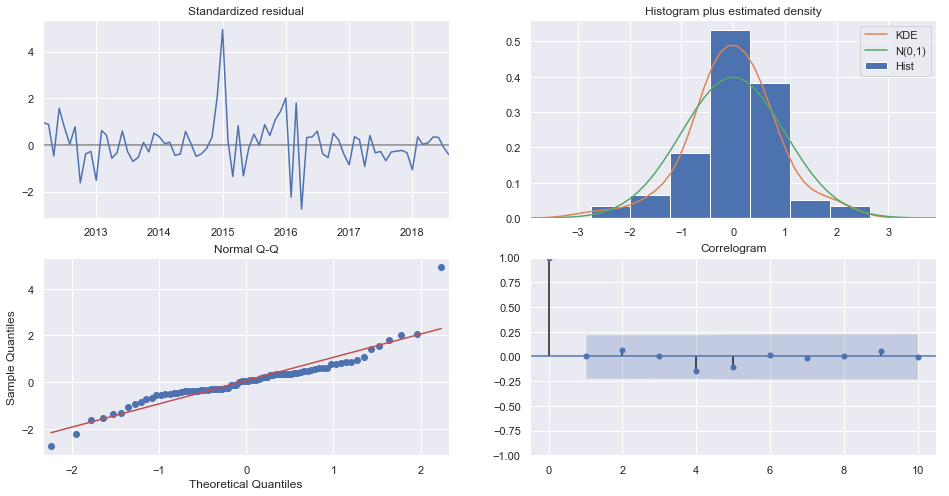

In [47]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()